In [1]:
# Import libraries
import ee
import geemap
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import os


In [2]:
# Trigger the authentication flow
ee.Authenticate()

True

In [3]:
#code = input("Enter the authorization code: ")

In [4]:
# Initialize the library
ee.Initialize()

In [5]:
geemap.ee_initialize()

In [6]:
# Import the shapefile of the study extent
folder = "Data/Tana_River_Study_Extent_37S"
shp = "Tana_River_Study_Extent_37S.shp"

# Check if the folder exists
if not os.path.exists:
    os.mkdir(folder)

# Join the file name with the folder
file_path = os.path.join(folder, shp)
study_Extent = gpd.read_file(file_path)


# Verify if the shapefile exists at the specified path
if os.path.exists(file_path):
    # Read the shapefile using the correct file path
    study_extent = gpd.read_file(file_path)
    print("Shapefile successfully loaded")
else:
    print(f"Shapefile not found at {file_path}. Please check the file path and ensure the file exists")


print(type(study_Extent))
print(study_Extent.geometry)


Shapefile successfully loaded
<class 'geopandas.geodataframe.GeoDataFrame'>
0    POLYGON ((565488.359 9949320.867, 571806.521 9...
Name: geometry, dtype: geometry


In [7]:
# Convert the GeoDataFrame to an GEE object
roi = geemap.geopandas_to_ee(study_extent)

## Load and Download Images

In [8]:
# Load the image during the flood
s2_Image_flood = ee.Image("COPERNICUS/S2_SR_HARMONIZED/20240429T072621_20240429T074427_T37MEV")
s2_Image_flood = s2_Image_flood.clip(roi)

In [9]:
# Create an interactive map
Map1 = geemap.Map(center=[-0.5288, 39.6800], zoom = 12)
Map1.add_basemap("ROADMAP")

In [10]:
# Visualize the image during the flood
s2_Viz = {"min":0.0, "max":3000, "bands":["B4", "B3", "B2"]}
Map1.addLayer(s2_Image_flood, s2_Viz, "s2_Image_flood")
Map1
#Map.centerObject(s2_Image_flood, 8)

Map(center=[-0.5288, 39.68], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [11]:
# Load Pre_flood images
tiles = ["37MEV", "37MEU", "37MFV"]
s2_Collection_pre = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                .filterDate("2024-01-10","2024-01-30")
                .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 50)
                .filterBounds(roi)
                .filter(ee.Filter.inList("MGRS_TILE", tiles))
)

In [12]:
# Check the numbers of image in the collection
print("The number of available images before flood is:", s2_Collection_pre.size().getInfo())

The number of available images before flood is: 2


In [13]:
# Create a mosaic from the s2_Collection_Pre

s2_Image_pre = s2_Collection_pre.mosaic().clip(roi)

In [14]:
# Visualize the image before the flood
Map2 = geemap.Map(center=[-0.5288, 39.6800], zoom = 12)
Map2.addLayer(s2_Image_pre, s2_Viz, "s2_Image_pre")
Map2

Map(center=[-0.5288, 39.68], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

## Flood Extent Mapping Using MNDWI

In [15]:
# Compute the MNDWI before flood
s2_Mndwi_pre = s2_Image_pre.normalizedDifference(["B3", "B11"]).rename("MNDWI")

In [16]:
# Visualize the MNDWI before flood
mndwi_Viz = {min:0.01, max:0.8, "palette":["#f7fbff", "#1452d9"]}

Map3 = geemap.Map(center=[-0.5288, 39.6800], zoom = 12)
Map3.addLayer(s2_Mndwi_pre, mndwi_Viz)
Map3

Map(center=[-0.5288, 39.68], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [17]:
# Compute the MNDWI during flood
s2_Mndwi_flood = s2_Image_flood.normalizedDifference(["B3","B11"]).rename("MNDWI")
s2_Mndwi_flood = s2_Mndwi_flood.select("MNDWI")

In [18]:
# Visualize the MNDWI before flood
Map4 = geemap.Map(center=[-0.5288, 39.6800], zoom = 12)

Map4.addLayer(s2_Mndwi_flood, mndwi_Viz)
Map4

Map(center=[-0.5288, 39.68], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [19]:
# Define a function that accepts an MNDWI layer and threshold value and return a mask layer
def water_mask(layer, threshold):
    mask = layer.gt(threshold).rename("water_mask").selfMask()
    return mask


In [20]:
# Extract permanent water body from the s2_mndwi_pre
perm_water = water_mask(s2_Mndwi_pre, 0.01)

In [21]:
# Extract flooded extent PLUS permanent water body from the s2_Mndwi_flood
flood_water = water_mask(s2_Mndwi_flood, 0.01)

In [22]:
# Mask out Permanent water bodies to get JUST the flood extent

# First Create a mask for the non permanent water
notPermWaterMask = s2_Mndwi_pre.lt(0.01).selfMask()

# Extract the flooded extent only
flooded = flood_water.updateMask(notPermWaterMask)

In [23]:
# Smooth the flooded extent layer to get a refined 
threshold = 6
connection = flooded.connectedPixelCount(26)
flooded = flooded.updateMask(connection.gt(threshold))

In [24]:
# Visualize the permanent water body overlaied on the flood layer
water_Viz = {min:0.0, max:0.9, "palette": ["#f7fbff", "#71c5f6"]}

Map5 = geemap.Map(center=[-0.5288, 39.6800], zoom = 13)
Map5.addLayer(flooded, {min: 0.0, max:0.9, "palette": ["blue"]},"flooded")
Map5

Map(center=[-0.5288, 39.68], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [25]:
# Convert the binary image to integer with values 0 and 1
flooded_int = flooded.multiply(255).toInt()

## Flood Damage Assessment

In [26]:
# Load and visualize the ESA land cover data

esa_LC = ee.ImageCollection('ESA/WorldCover/v200').first().clip(roi)

vis_lc = {"bands": ['Map']}

Map6 = geemap.Map(center=[-0.5288, 39.6800], zoom = 13)
Map6.addLayer(esa_LC, vis_lc, 'Landcover')
Map6

Map(center=[-0.5288, 39.68], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [27]:
# Create a function that export a GEE layer to GTiff 

def gee_to_tiff(input_layer, out_folder, output_filename):
    
    try:
        if not os.path.exists(out_folder):
            os.mkdir(out_folder)
        file_name = os.path.join(out_folder, output_filename)
        
        # Export a GEE layer to raster Gtiff
        raster = geemap.ee_export_image(
            input_layer,
            file_name,
            scale = 10,
            region = roi.geometry(),
            crs= "EPSG:32737",
            file_per_band = False
        )
        return raster
    except Exception as e:
        print("An erro has occurred:", e)

In [28]:
# Export the land cover layer as a tiff file
gee_to_tiff(esa_LC, "Outputs", "landcover.tif")

Generating URL ...
Please wait ...
Data downloaded to d:\Lukumon_Projects\Flood-Extent-Mapping-And-Damage-Assessment-Tana-River-Kenya\Outputs\landcover.tif


In [29]:
# Create a function that converts a GEE raster layer to vector and dissolve the vector
    
def raster_to_vector(input_layer, out_folder, output_shp):

    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
        
    file_name = os.path.join(out_folder, output_shp)
    #output_file = os.path.join(out_folder, output_shp)

    # Convert raster to vector
    vector = input_layer.reduceToVectors(
        geometry= roi.geometry(),
        crs= "EPSG:32737",
        scale= 10,
        geometryType='polygon',
        bestEffort=True,
        maxPixels=1e8,
        #tileScale=4
    )
    
    # convert the ee vector to shapefile and read to gdf 
    geemap.ee_to_shp(vector, file_name) 
    shp = gpd.read_file(file_name)

    # Dissolve the shapefile
    print("Attributes in the shapefile:", shp.columns) # Check for the column to dissolve
    shp_disv = shp.dissolve(by="label") # You may need to change the "label" argument depending on the attributes in your input
    shp_disv = shp_disv.to_crs("EPSG:32737")
    
    # Add Area attribute to the dissolved shapefile
    shp_disv["Area_km2"] = (shp_disv.geometry.area) / 1e6 
    print(shp_disv.crs) 
    
    # Export the shapefile
    output_shp = shp_disv.to_file(file_name, driver='ESRI Shapefile')

    return output_shp

In [30]:
# Convert the flooded extent from raster to vector
raster_to_vector(flooded_int, "Outputs", "flood_disv.shp")

Attributes in the shapefile: Index(['count', 'label', 'geometry'], dtype='object')
EPSG:32737


In [31]:
# Convert the land cover from raster to vector
raster_to_vector(esa_LC, "Outputs", "lc_disv.shp")

Attributes in the shapefile: Index(['count', 'label', 'geometry'], dtype='object')
EPSG:32737


In [32]:
# Write a function to determine the number of buildings affected by the flood
def building_damage(flood_shp, output_shp):

    out_folder = "Outputs"
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)

    flood_extent = os.path.join(out_folder, flood_shp)
    output_file = os.path.join(out_folder, output_shp)

    # Load the flooded shapefile
    gdf_flood = gpd.read_file(flood_extent)
    gdf_flood = gdf_flood.to_crs("EPSG:4326")
    
    # Convert it to shapely polygon
    if gdf_flood.geometry.count() > 1:
        flood_poly = gdf_flood.unary_union
    else:
        flood_poly = gdf_flood.geometry.iloc[0]

    # Load osm building footprint data with the boundary of the flooded extent
    tags = {"building": True}
    bdg = ox.features_from_polygon(flood_poly, tags=tags)

    # Perform intersection to determine the buildings affected by the flood
    affected_bdg = gpd.sjoin(bdg, gdf_flood, how="inner", predicate="intersects")
    print(affected_bdg.columns)

    affected_bdg = affected_bdg.to_crs("EPSG:32737")
    # Export the shapefiles of affected buildings and select a few columns
    columns = ["geometry"] 
    affected_bdg_shp = affected_bdg[columns].to_file(output_file, driver='ESRI Shapefile')

    # Count the number of buildings
    print (f"{len(affected_bdg)} buildings were affected by the flood.")

    return affected_bdg_shp



In [33]:
# Determine the affected building
building_damage("flood_disv.shp", "affected_bdg.shp")

Index(['geometry', 'nodes', 'building', 'ways', 'type', 'index_right', 'label',
       'count', 'Area_km2'],
      dtype='object')


C:\Users\legion\AppData\Local\Temp\ipykernel_42392\1403484028.py:32: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  affected_bdg_shp = affected_bdg[columns].to_file(output_file, driver='ESRI Shapefile')


2080 buildings were affected by the flood.


In [34]:
# Land cover attribute information
lc_bands = {
    10: "Tree cover", 
    20: "Shrubland", 
    30: "Grassland", 
    40: "Cropland", 
    50: "Built-up", 
    60: "Bare / Sparse Vegetation", 
    90: "Mangroves" 
} 

In [35]:
# Write a function to determine the exent of land cover affected by the flood
def landcover_damage(flood_shp, lc_shp, output_shp):

    out_folder = "Outputs"
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)

    flood_extent = os.path.join(out_folder, flood_shp)
    lc_extent = os.path.join(out_folder, lc_shp)
    output_file = os.path.join(out_folder, output_shp)

    # Load the flooded shapefile and the land cover shapefile
    gdf_flood = gpd.read_file(flood_extent)
    gdf_lc = gpd.read_file(lc_extent)
    
    # Perform intersection operation to determine the affected land cover
    affected_lc = gpd.overlay(gdf_flood, gdf_lc, how= "intersection", keep_geom_type=True)
    print(affected_lc.columns)
    
    # Drop and rename columns
    affected_lc.drop(columns=["label_1", "count_1", "Area_km2_1", "count_2", "Area_km2_2"], inplace = True)
    affected_lc.rename(columns={"label_2": "label",}, inplace = True) 

    # Remove permanent water bodies
    affected_lc.drop(affected_lc[affected_lc['label'] == 80].index, inplace=True)

    # Add the class column based on the label / map the name of the land covers 
    affected_lc['class'] = affected_lc['label'].map(lc_bands)

    # Re-compute the areas
    affected_lc["Area_km2"] = ((affected_lc.geometry.area) / 1e6).round(3)
    print(affected_lc.head())

    # Export the shapefiles of affected land cover
    affected_lc_shp = affected_lc.to_file(output_file, driver='ESRI Shapefile')

    return affected_lc_shp



In [36]:
# Determine the affected land cover
landcover_damage("flood_disv.shp", "lc_disv.shp", "affected_lc_disv.shp")

Index(['label_1', 'count_1', 'Area_km2_1', 'label_2', 'count_2', 'Area_km2_2',
       'geometry'],
      dtype='object')
   label                                           geometry       class  \
0     10  MULTIPOLYGON (((568640.000 9947499.369, 568640...  Tree cover   
1     20  MULTIPOLYGON (((568980.000 9946520.000, 568980...   Shrubland   
2     30  MULTIPOLYGON (((568360.000 9948080.000, 568350...   Grassland   
3     40  MULTIPOLYGON (((568650.000 9947180.000, 568660...    Cropland   
4     50  MULTIPOLYGON (((568540.000 9948200.000, 568560...    Built-up   

   Area_km2  
0     8.059  
1    14.991  
2     1.223  
3    14.386  
4     0.277  


## Visualize the Results of the Damage Assessment

In [37]:
# Read the affected buildings and affected land cover files into GeodataFrames
affected_bdg = gpd.read_file("Outputs/affected_bdg.shp")
affected_lc = gpd.read_file("Outputs/affected_lc_disv.shp")

In [38]:
# Inspect the affected land cover
affected_lc.info()
affected_lc.head(10)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   label     7 non-null      int64   
 1   class     7 non-null      object  
 2   Area_km2  7 non-null      float64 
 3   geometry  7 non-null      geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 356.0+ bytes


,label,class,Area_km2,geometry
0,10,Tree cover,8.059,"MULTIPOLYGON (((568640.000 9947499.369, 568640..."
1,20,Shrubland,14.991,"MULTIPOLYGON (((568980.000 9946520.000, 568980..."
2,30,Grassland,1.223,"MULTIPOLYGON (((568360.000 9948080.000, 568350..."
3,40,Cropland,14.386,"MULTIPOLYGON (((568650.000 9947180.000, 568660..."
4,50,Built-up,0.277,"MULTIPOLYGON (((568540.000 9948200.000, 568560..."
5,60,Bare / Sparse Vegetation,0.231,"MULTIPOLYGON (((569800.000 9946898.986, 569800..."
6,90,Mangroves,1.465,"MULTIPOLYGON (((568810.000 9947490.000, 568810..."


In [39]:
# Visualize the affected land cover types

# Define the color map for the classes
lc_bands_colors = {
    "Tree cover": "#006400",
    "Shrubland": "#ffbb22",
    "Grassland": "#fae500",
    "Cropland": "#ad89dd",
    "Built-up": "#e31a1c",
    "Bare / Sparse Vegetation": "#d4dadc",
    "Mangroves": "#1ec61e"
}

# Function to style each feature based on the class
def style_function(feature):
    return {
        'fillColor': lc_bands_colors.get(feature['properties']['class'], 'black'),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.6,
    }

# Initialize a geemap map
m = geemap.Map()

# Add GeoDataFrame to the map using add_gdf with style_callback
m.add_gdf(
    affected_lc,
    layer_name="Affected Land Cover",
    style={},
    hover_style={'fillOpacity': 0.8},
    style_callback=style_function,
    info_mode="on_hover",
    zoom_to_layer=True
)

# Display the map
m


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

<Axes: >

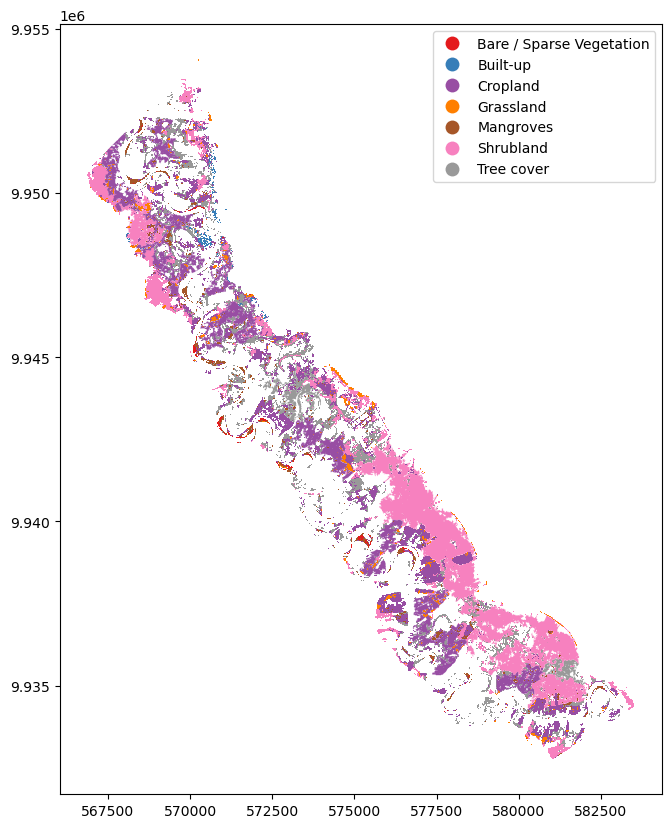

In [40]:
fig, ax = plt.subplots(1, figsize=(15, 10))

# Visualize the affected land cover types
affected_lc.plot(
    "class", 
    legend=True,
    cmap ="Set1",
    ax=ax    
)

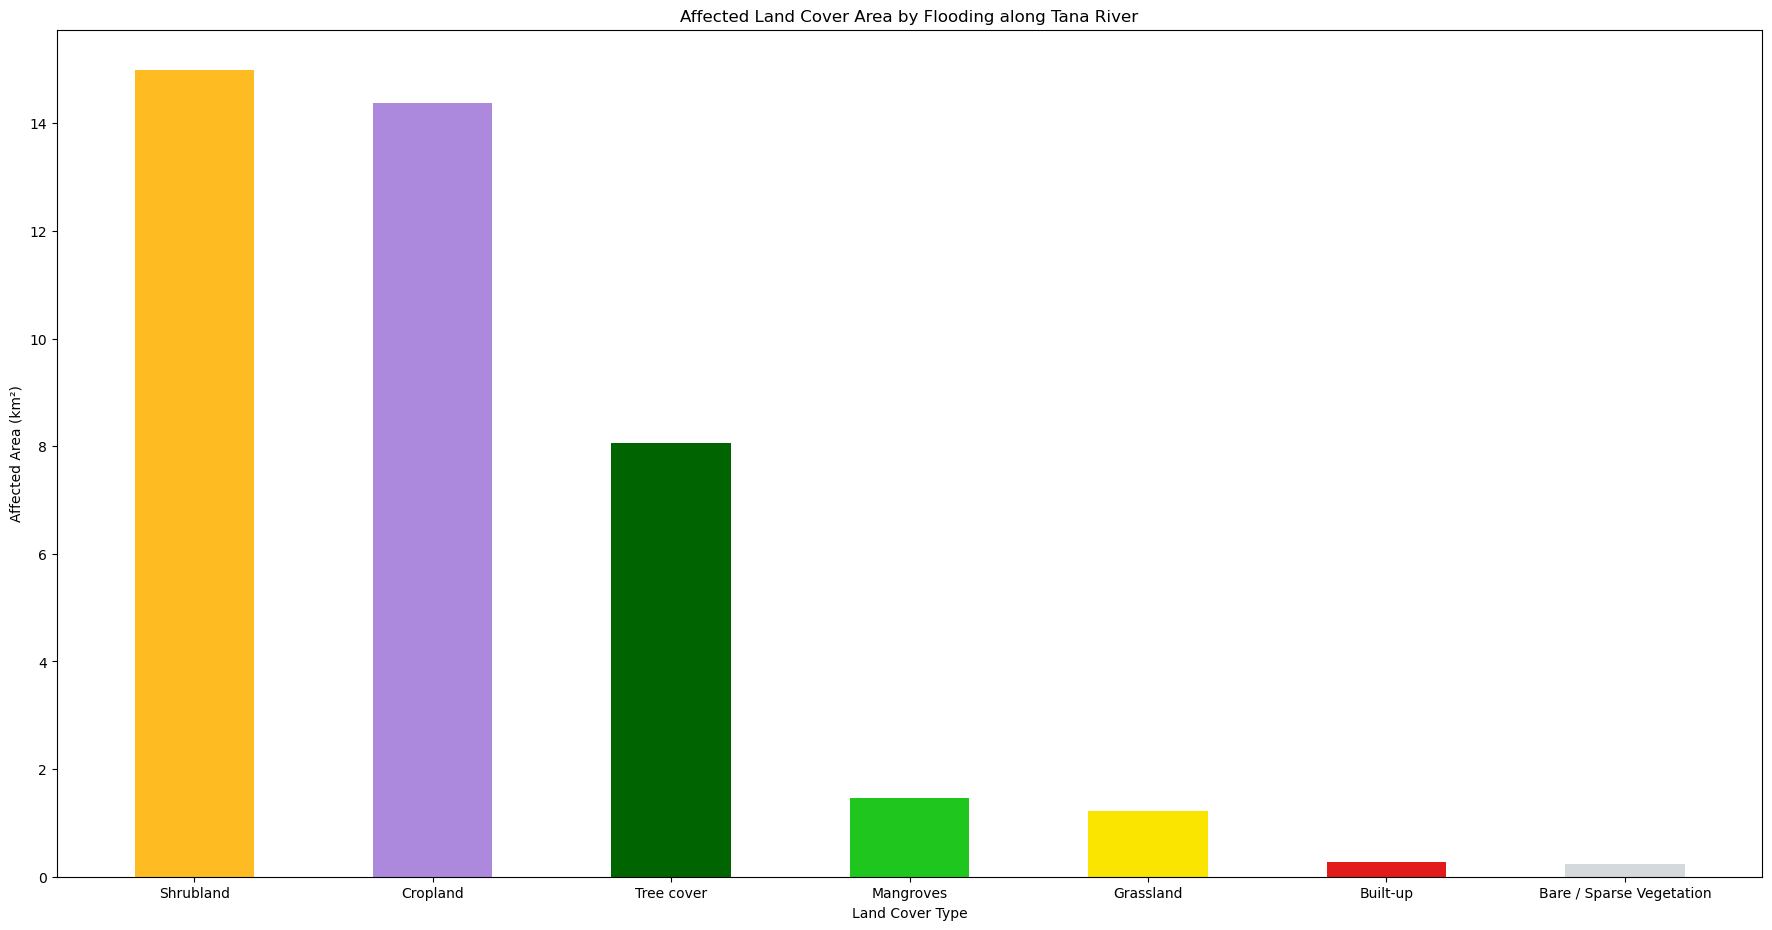

In [41]:
# Create a bar chart to see the area affected for each land cover class

# List of colors for the bars based on the order of Area_km2
colors = ["#ffbb22", "#ad89dd", "#006400", "#1ec61e", "#fae500", "#e31a1c", "#d4dadc"]

# Ensure that the number of colors is equal to the number of land cover classes
if len(colors) < affected_lc.shape[0]:
    raise ValueError("Not enough colors for the number of land cover classes.")

# Sort the DataFrame by 'Area_km2' in descending order
affected_lc_sorted = affected_lc.sort_values(by='Area_km2', ascending=False)

fig, ax = plt.subplots(1, figsize=(22, 11))

# Plot the bars with different colors
ax.bar(affected_lc_sorted["class"], affected_lc_sorted["Area_km2"], color=colors[:affected_lc.shape[0]], width=0.5)

# Add labels and title
plt.xlabel("Land Cover Type")
plt.ylabel("Affected Area (km²)")
plt.title("Affected Land Cover Area by Flooding along Tana River");

In [42]:
# Inspect the affected buildings
affected_bdg.info()
affected_bdg.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2080 entries, 0 to 2079
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   element_ty  2080 non-null   object  
 1   osmid       2080 non-null   int64   
 2   geometry    2080 non-null   geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 48.9+ KB


,element_ty,osmid,geometry
0,way,209429218,"POLYGON ((570230.194 9948130.662, 570234.556 9..."
1,way,209429231,"POLYGON ((570256.792 9948283.223, 570256.793 9..."
2,way,209429233,"POLYGON ((570206.537 9948143.752, 570205.191 9..."
3,way,209429239,"POLYGON ((570276.338 9948218.579, 570279.287 9..."
4,way,209431885,"POLYGON ((572044.960 9946667.702, 572039.432 9..."


In [43]:
# Visualize the affected buildings
affected_bdg.explore()